In [67]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import plotly.express as px
from mlxtend.preprocessing import TransactionEncoder
from mlxtend.frequent_patterns import apriori, association_rules
import numpy as np


In [68]:
df = pd.read_excel('US+Candy+Distributor/candydistributors.xlsx', sheet_name='candydistributor' )
df['count'] = 1
df.columns

Index(['rowid', 'distances', 'customerid', 'orderid', 'orderdate', 'orderyear',
       'ordermonth', 'shipdate', 'shipyear', 'shipmonth', 'deliverytime',
       'countryregion', 'stateprovince', 'postalcode', 'lat', 'lng', 'stateid',
       'statename', 'countyfips', 'countyname', 'latitude', 'longitude',
       'factory', 'productname', 'productid', 'division', 'units', 'unitcost',
       'unitprice', 'cost', 'grossprofit', 'rangeprofit', 'sales', 'rangsales',
       'distancetype', 'shipmode', 'region', 'city', 'populationtype',
       'population', 'count'],
      dtype='object')

In [69]:
# Convertir la colonne 'orderdate' en type datetime
df['orderdate'] = pd.to_datetime(df['orderdate'])

df['year'] = df['orderdate'].dt.year
df['month'] = df['orderdate'].dt.month

df['month_name'] = df['orderdate'].dt.month_name()

df = df.sort_values(by='month', ascending=True)

In [70]:
df['orderyear'] = df['orderyear'].astype(str)
pivot = df.pivot_table(
    values='grossprofit',  
    index='orderyear',     
    columns='factory',     
    aggfunc='mean'         
)
pivot = pivot.round(2)
pivot

factory,Lot's O' Nuts,Secret Factory,Sugar Shack,The Other Factory,Wicked Choccy's
orderyear,,,,,
2021,9.08,20.90,4.54,0.92,8.70
2022,9.23,15.23,2.98,1.05,8.82
2023,9.43,23.68,3.47,2.16,8.58
2024,9.21,18.56,3.75,1.87,8.68


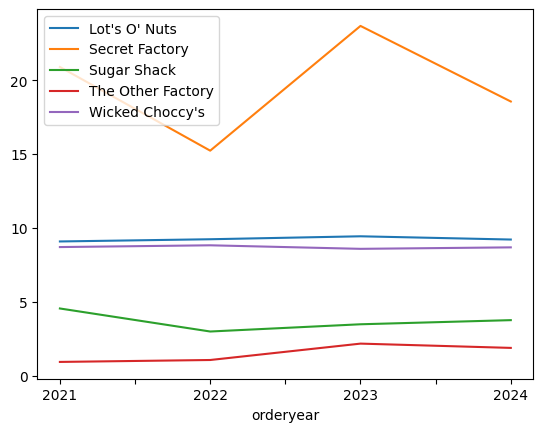

In [71]:
pivot.plot()
plt.legend()

In [104]:
month_order = [
    "January", "February", "March", "April", "May", "June", 
    "July", "August", "September", "October", "November", "December"
]

# Convertir 'month_name' en catégorie avec un ordre spécifique
df['month_name'] = pd.Categorical(df['month_name'], categories=month_order, ordered=True)

df['orderyear'] = df['orderyear'].astype(str)
pivot = df.pivot_table(
    values='count',  
    index='orderyear',     
    columns='month_name',     
    aggfunc='sum'         
)
pivot = pivot.round(2)
pivot

/tmp/ipykernel_15038/255154774.py:10: FutureWarning: The default value of observed=False is deprecated and will change to observed=True in a future version of pandas. Specify observed=False to silence this warning and retain the current behavior
  pivot = df.pivot_table(


month_name,January,February,March,April,May,June,July,August,September,October,November,December
orderyear,,,,,,,,,,,,
2021,61,40,132,113,118,118,113,131,234,138,267,253
2022,54,57,123,126,127,109,110,129,245,137,269,278
2023,83,71,153,146,184,171,168,149,317,169,307,305
2024,126,95,203,182,215,211,197,183,381,266,394,391


<Axes: xlabel='month_name'>

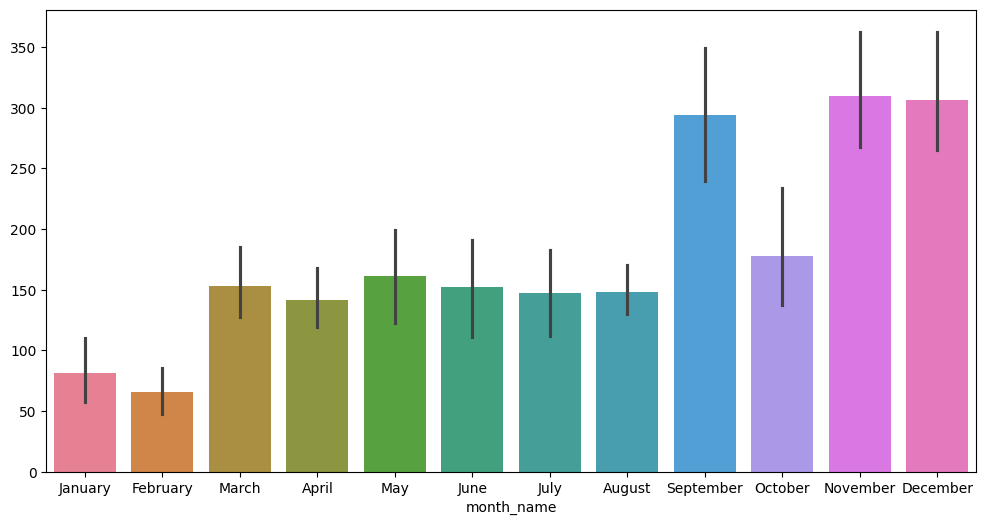

In [105]:
plt.figure(figsize=(12, 6))
sns.barplot(pivot)


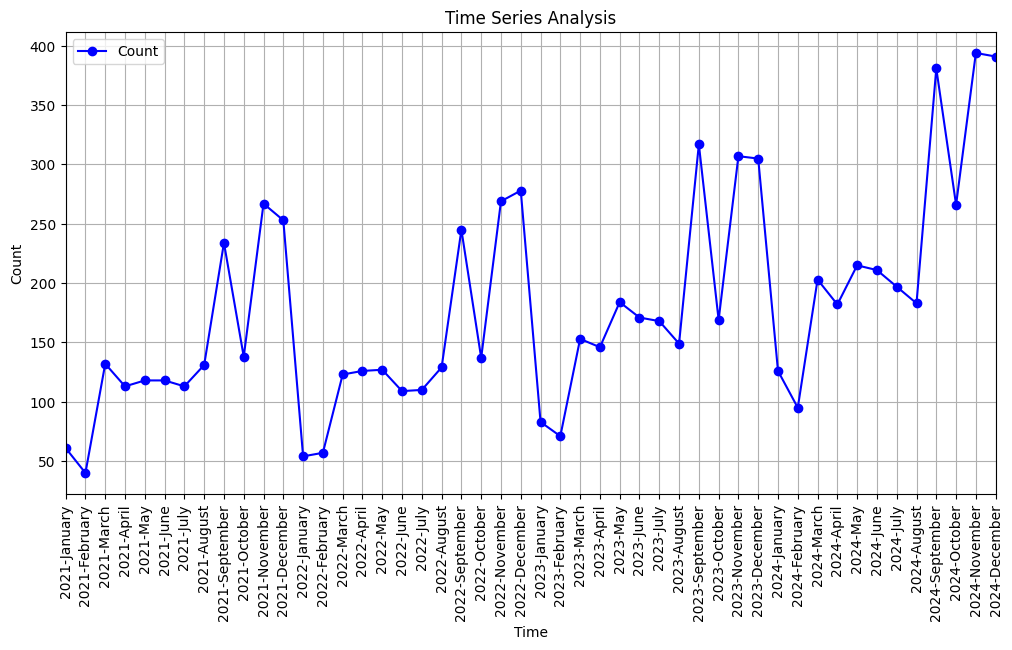

In [106]:

# Réinitialiser l'index pour convertir en un format utilisable pour une série temporelle
pivot.reset_index(inplace=True)

# Fusionner 'orderyear' et 'month_name' pour créer un index temporel
pivot_melted = pivot.melt(id_vars='orderyear', var_name='month_name', value_name='count')
month_order = [
    "January", "February", "March", "April", "May", "June", 
    "July", "August", "September", "October", "November", "December"
]

# Convertir les données en série temporelle
pivot_melted['month'] = pivot_melted['month_name'].apply(lambda x: month_order.index(x) + 1)
pivot_melted['date'] = pd.to_datetime(pivot_melted['orderyear'].astype(str) + '-' + pivot_melted['month'].astype(str))

# Trier par date
pivot_melted = pivot_melted.sort_values('date')

# Créer une série temporelle
time_series = pivot_melted.set_index('date')['count']

# Tracer la série temporelle
plt.figure(figsize=(12, 6))
time_series.plot(marker='o', linestyle='-', color='b', label='Count')
plt.title('Time Series Analysis')
plt.ylabel('Count')
plt.xlabel('Time')
plt.grid(True)
plt.legend()

# Ajouter tous les ticks sur l'axe des abscisses
plt.xticks(ticks=time_series.index, labels=time_series.index.strftime('%Y-%B'), rotation=90)

plt.show()

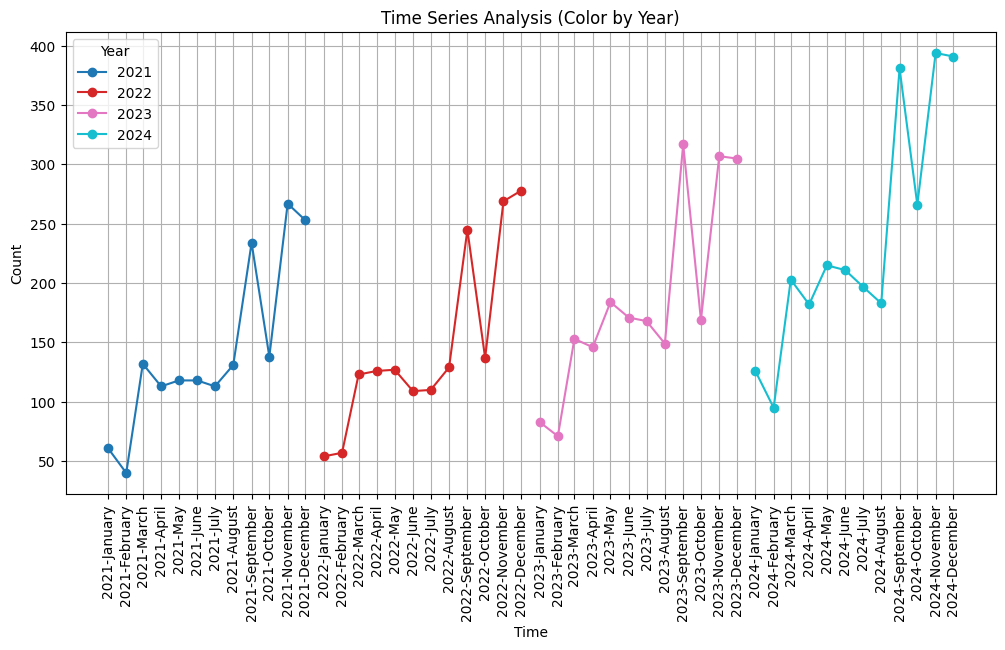

In [112]:
plt.figure(figsize=(12, 6))
years = time_series.index.year.unique()  # Liste des années uniques
colors = plt.cm.tab10(np.linspace(0, 1, len(years)))  # Palette de couleurs pour chaque année

for year, color in zip(years, colors):
    data_per_year = time_series[time_series.index.year == year]
    plt.plot(data_per_year.index, data_per_year, marker='o', linestyle='-', label=str(year), color=color)

# Ajouter des informations au graphique
plt.title('Time Series Analysis (Color by Year)')
plt.ylabel('Count')
plt.xlabel('Time')
plt.grid(True)
plt.legend(title="Year")
plt.xticks(rotation=90)
plt.xticks(ticks=time_series.index, labels=time_series.index.strftime('%Y-%B'), rotation=90)
plt.show()


/tmp/ipykernel_15038/2930745008.py:2: FutureWarning: 'Q' is deprecated and will be removed in a future version, please use 'QE' instead.
  quarterly_data = time_series.resample('Q').mean()


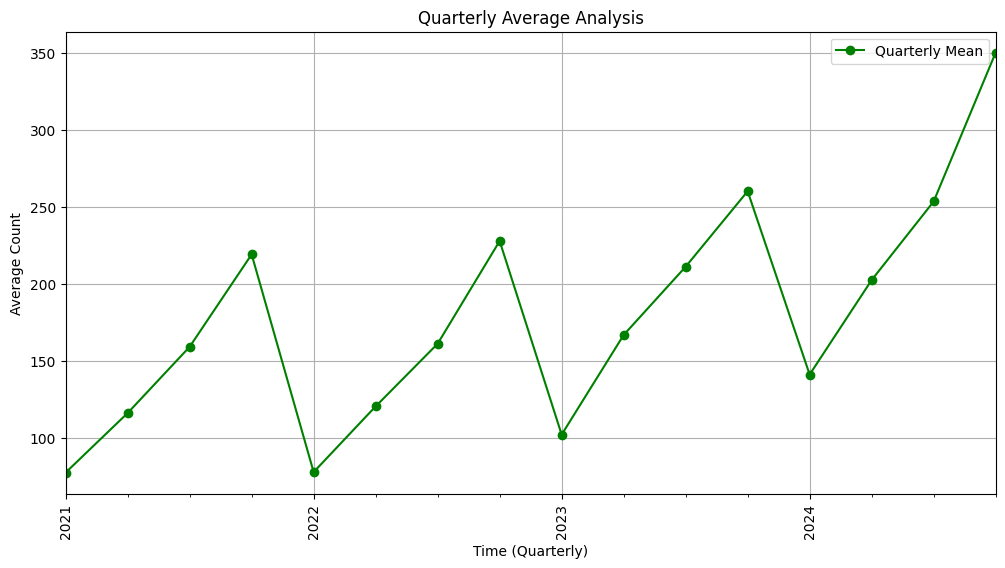

In [75]:
# Grouper par trimestre et calculer la moyenne
quarterly_data = time_series.resample('Q').mean()

# Tracer le graphique
plt.figure(figsize=(12, 6))
quarterly_data.plot(marker='o', linestyle='-', color='g', label='Quarterly Mean')

# Configurer le graphique
plt.title('Quarterly Average Analysis')
plt.ylabel('Average Count')
plt.xlabel('Time (Quarterly)')
plt.grid(True)
plt.legend()

# Afficher toutes les abscisses et les pivoter
plt.xticks(rotation=90)

# Afficher le graphique
plt.show()


/tmp/ipykernel_15038/1178665808.py:11: FutureWarning: The default value of observed=False is deprecated and will change to observed=True in a future version of pandas. Specify observed=False to silence this warning and retain the current behavior
  pivot = filtered_df.pivot_table(
/tmp/ipykernel_15038/1178665808.py:11: FutureWarning: The default value of observed=False is deprecated and will change to observed=True in a future version of pandas. Specify observed=False to silence this warning and retain the current behavior
  pivot = filtered_df.pivot_table(
/tmp/ipykernel_15038/1178665808.py:11: FutureWarning: The default value of observed=False is deprecated and will change to observed=True in a future version of pandas. Specify observed=False to silence this warning and retain the current behavior
  pivot = filtered_df.pivot_table(


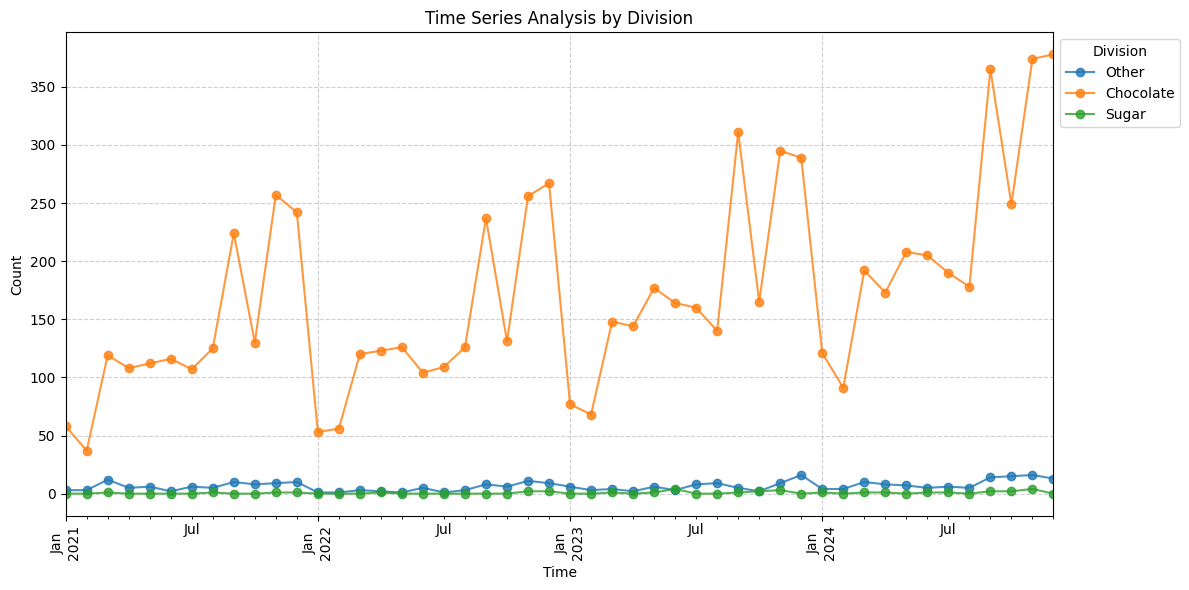

In [76]:
colors = plt.cm.tab10(range(len(df['division'].unique())))

plt.figure(figsize=(12, 6))

# Boucle pour chaque division
for i, division in enumerate(df['division'].unique()):
    # Filtrer les données pour la division actuelle
    filtered_df = df[df['division'] == division]

    # Pivot table
    pivot = filtered_df.pivot_table(
        values='count',  
        index='orderyear',     
        columns='month_name',     
        aggfunc='sum'         
    ).fillna(0)  # Remplacer les valeurs manquantes par 0
    
    # Réinitialiser l'index pour convertir en un format utilisable pour une série temporelle
    pivot.reset_index(inplace=True)

    # Fusionner 'orderyear' et 'month_name' pour créer un index temporel
    pivot_melted = pivot.melt(id_vars='orderyear', var_name='month_name', value_name='count')
    month_order = [
        "January", "February", "March", "April", "May", "June", 
        "July", "August", "September", "October", "November", "December"
    ]
    pivot_melted['month'] = pivot_melted['month_name'].apply(lambda x: month_order.index(x) + 1)
    pivot_melted['date'] = pd.to_datetime(pivot_melted['orderyear'].astype(str) + '-' + pivot_melted['month'].astype(str))

    # Trier par date
    pivot_melted = pivot_melted.sort_values('date')

    # Créer une série temporelle
    time_series = pivot_melted.set_index('date')['count']

    # Tracer la série temporelle
    time_series.plot(
        marker='o', 
        linestyle='-', 
        color=colors[i], 
        label=division, 
        alpha=0.8
    )

# Configurer le graphique
plt.title('Time Series Analysis by Division')
plt.ylabel('Count')
plt.xlabel('Time')
plt.grid(True, linestyle='--', alpha=0.6)
plt.legend(title='Division', loc='upper left', bbox_to_anchor=(1, 1))  # Légende hors du graphique
plt.xticks(rotation=90)
plt.tight_layout()  # Ajuster les marges pour éviter le chevauchement

# Afficher le graphique
plt.show()


/tmp/ipykernel_15038/202235900.py:10: FutureWarning: The default value of observed=False is deprecated and will change to observed=True in a future version of pandas. Specify observed=False to silence this warning and retain the current behavior
  pivot = filtered_df.pivot_table(
/tmp/ipykernel_15038/202235900.py:10: FutureWarning: The default value of observed=False is deprecated and will change to observed=True in a future version of pandas. Specify observed=False to silence this warning and retain the current behavior
  pivot = filtered_df.pivot_table(


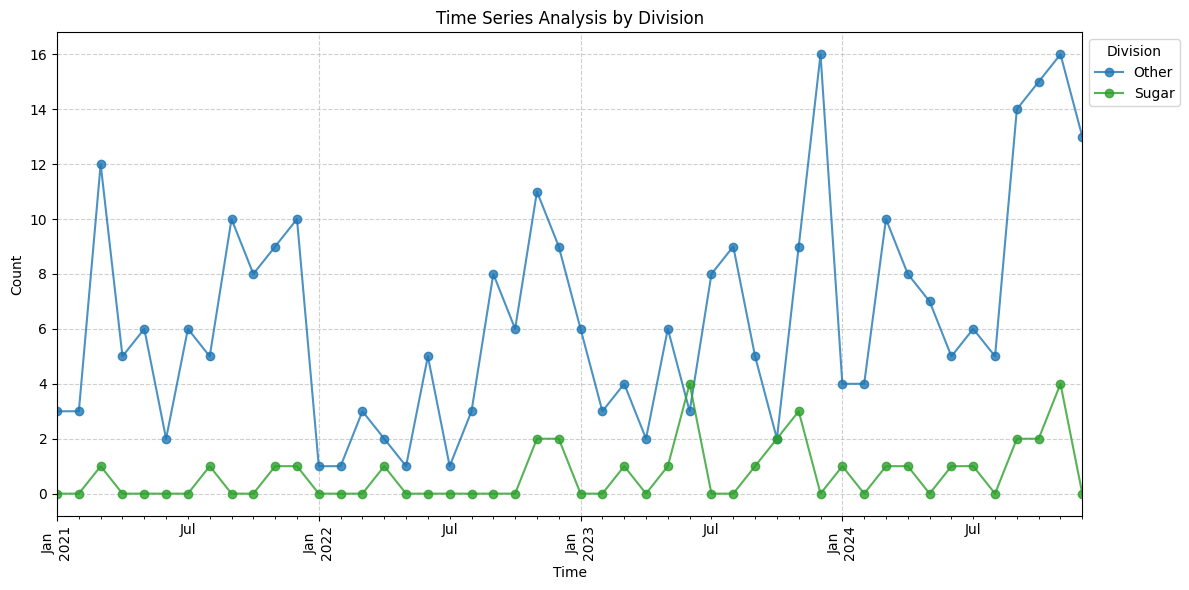

In [77]:
plt.figure(figsize=(12, 6))

# Boucle pour chaque division
for i, division in enumerate(df['division'].unique()) :
    # Filtrer les données pour la division actuelle
    if division=='Chocolate' : continue
    filtered_df = df[df['division'] == division]

    # Pivot table
    pivot = filtered_df.pivot_table(
        values='count',  
        index='orderyear',     
        columns='month_name',     
        aggfunc='sum'         
    ).fillna(0)  # Remplacer les valeurs manquantes par 0
    
    # Réinitialiser l'index pour convertir en un format utilisable pour une série temporelle
    pivot.reset_index(inplace=True)

    # Fusionner 'orderyear' et 'month_name' pour créer un index temporel
    pivot_melted = pivot.melt(id_vars='orderyear', var_name='month_name', value_name='count')
    month_order = [
        "January", "February", "March", "April", "May", "June", 
        "July", "August", "September", "October", "November", "December"
    ]
    pivot_melted['month'] = pivot_melted['month_name'].apply(lambda x: month_order.index(x) + 1)
    pivot_melted['date'] = pd.to_datetime(pivot_melted['orderyear'].astype(str) + '-' + pivot_melted['month'].astype(str))

    # Trier par date
    pivot_melted = pivot_melted.sort_values('date')

    # Créer une série temporelle
    time_series = pivot_melted.set_index('date')['count']

    # Tracer la série temporelle
    time_series.plot(
        marker='o', 
        linestyle='-', 
        color=colors[i], 
        label=division, 
        alpha=0.8
    )

# Configurer le graphique
plt.title('Time Series Analysis by Division')
plt.ylabel('Count')
plt.xlabel('Time')
plt.grid(True, linestyle='--', alpha=0.6)
plt.legend(title='Division', loc='upper left', bbox_to_anchor=(1, 1))  # Légende hors du graphique
plt.xticks(rotation=90)
plt.tight_layout()  # Ajuster les marges pour éviter le chevauchement

# Afficher le graphique
plt.show()


# Tous les produits

# Nombre de command par produit, sans compter les unités

In [78]:
# Comptage des occurrences de chaque produit
product_counts = df['productname'].value_counts().reset_index()
product_counts.columns = ['productname', 'count']
product_counts

,productname,count
0,Wonka Bar - Milk Chocolate,1768
1,Wonka Bar -Scrumdiddlyumptious,1704
2,Wonka Bar - Triple Dazzle Caramel,1677
3,Wonka Bar - Nutty Crunch Surprise,1529
4,Wonka Bar - Fudge Mallows,1527
5,Wonka Gum,118
6,Kazookles,94
7,Lickable Wallpaper,92
8,Laffy Taffy,10
9,SweeTARTS,10


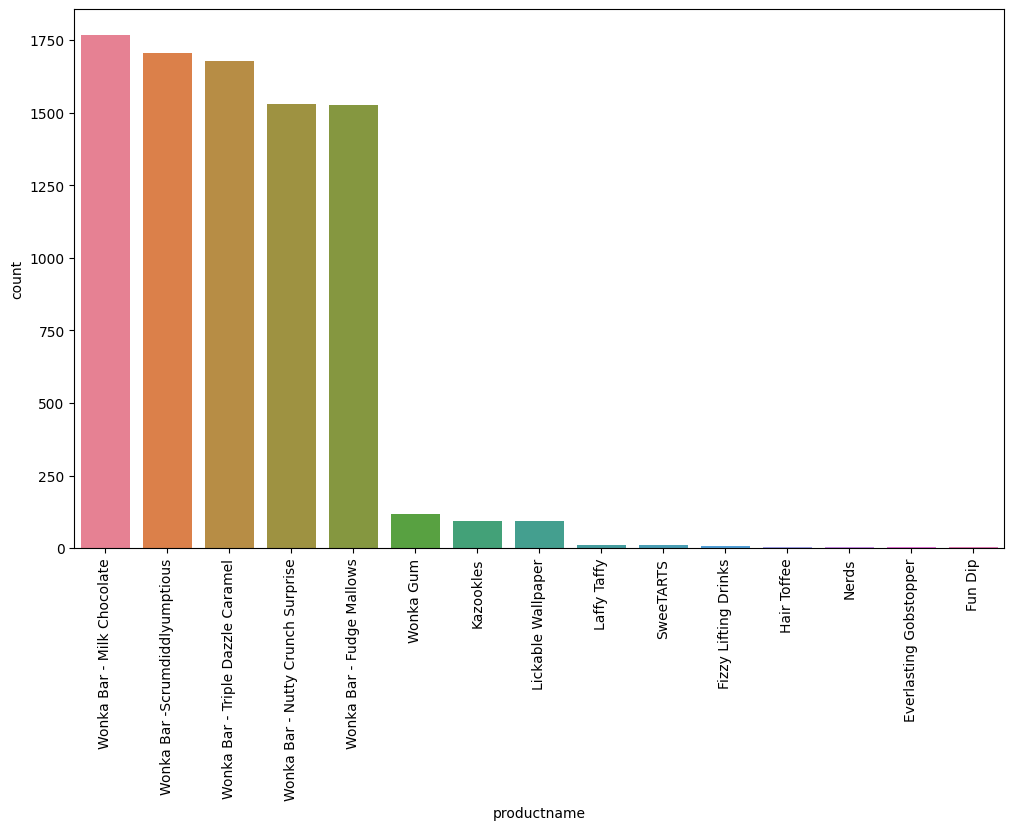

In [79]:


# Création du graphique en barres
plt.figure(figsize=(12, 7))
sns.barplot(data=product_counts, x='productname', y='count' , hue='productname')

plt.xticks(rotation=90)  # Rotation des noms des produits si nécessaire
plt.show()


# Nombre d'unite total de commande pour chaque produits

In [80]:
pivot = df.pivot_table(
    values='units',  
    index='productname',   
    aggfunc='sum'         
)
pivot = pivot.round(2)
pivot

,units
productname,
Everlasting Gobstopper,13
Fizzy Lifting Drinks,21
Fun Dip,8
Hair Toffee,17
Kazookles,366
Laffy Taffy,27
Lickable Wallpaper,383
Nerds,10
SweeTARTS,41


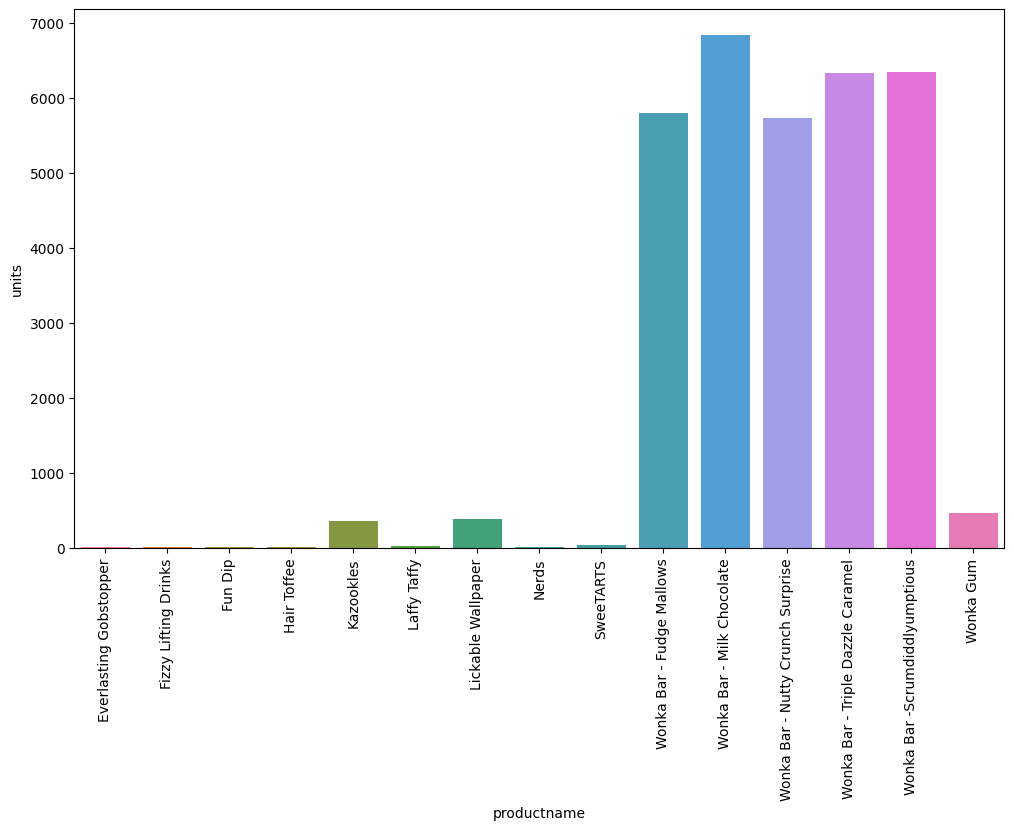

In [81]:
plt.figure(figsize=(12, 7))

sns.barplot(pivot , x='productname', y='units', hue='productname')
plt.xticks(rotation=90)  # Rotation des noms des produits si nécessaire
plt.show()

# Profit total générer par chaque produit au cours des 4 ans

In [82]:
pivot = df.pivot_table(
    values='grossprofit',  
    index='productname',   
    aggfunc='sum'         
)
pivot = pivot.round(2)
pivot

,grossprofit
productname,
Everlasting Gobstopper,104.00
Fizzy Lifting Drinks,47.25
Fun Dip,4.80
Hair Toffee,59.50
Kazookles,91.50
Laffy Taffy,33.48
Lickable Wallpaper,3830.00
Nerds,7.00
SweeTARTS,28.70


/tmp/ipykernel_15038/1886298593.py:5: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  plt.legend()


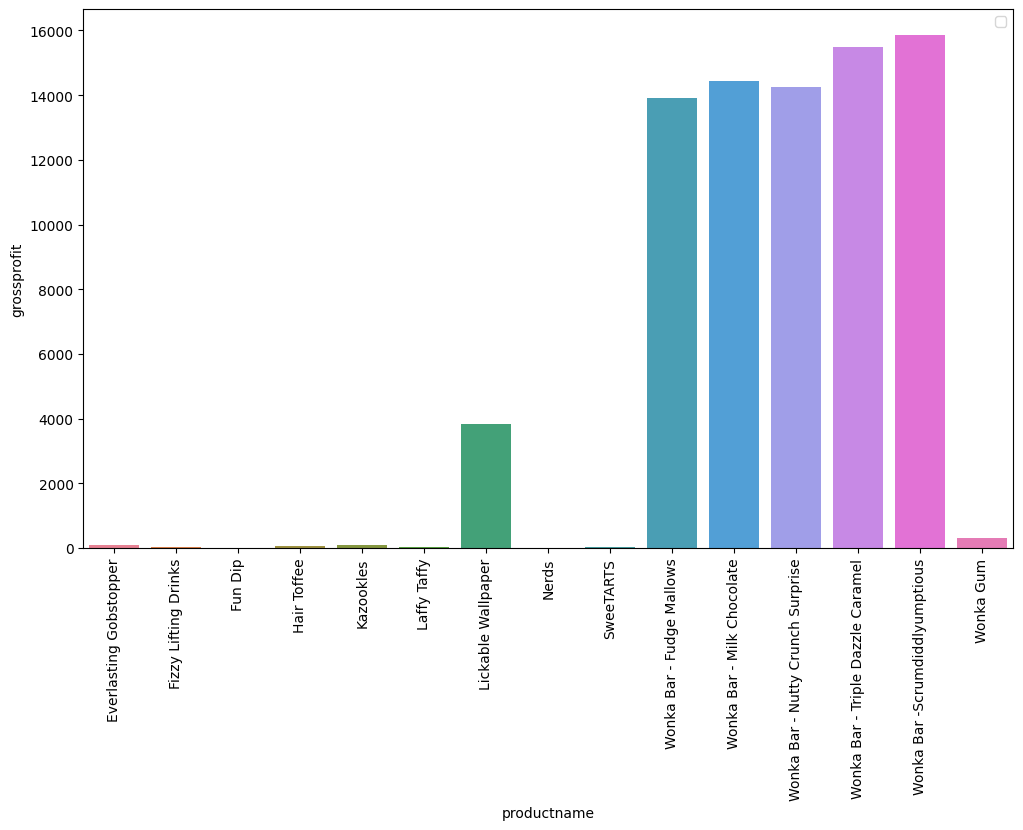

In [83]:
plt.figure(figsize=(12, 7))

sns.barplot(pivot , x='productname', y='grossprofit', hue='productname')
plt.xticks(rotation=90)  # Rotation des noms des produits si nécessaire
plt.legend()
plt.show()

# Chocolate

In [84]:
chocolate = df[df['division'] =='Chocolate']

<Axes: xlabel='region', ylabel='distances'>

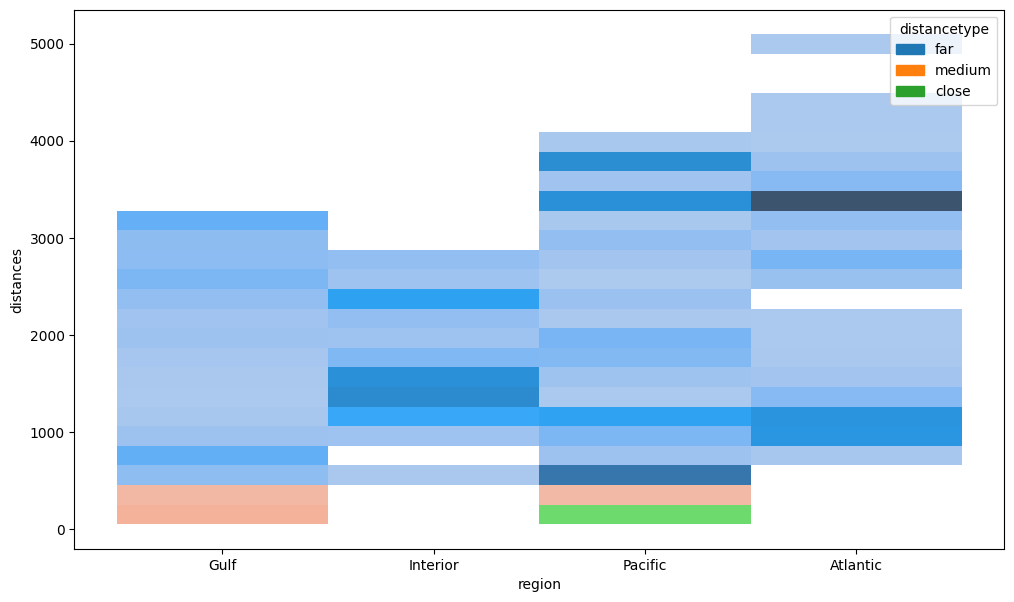

In [85]:
plt.figure(figsize=(12, 7))
sns.histplot(chocolate, x='region' ,  y='distances', hue='distancetype',  shrink=0.6)

<Axes: xlabel='region', ylabel='Count'>

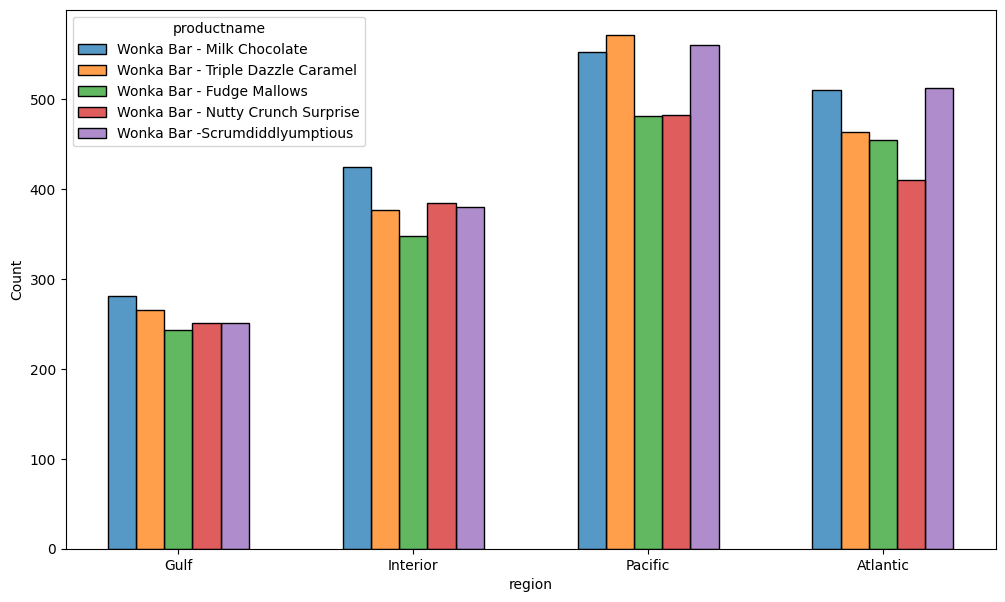

In [86]:
plt.figure(figsize=(12, 7))
sns.histplot(chocolate, x='region' ,  hue='productname', shrink=0.6,  multiple="dodge")

<Axes: xlabel='region', ylabel='grossprofit'>

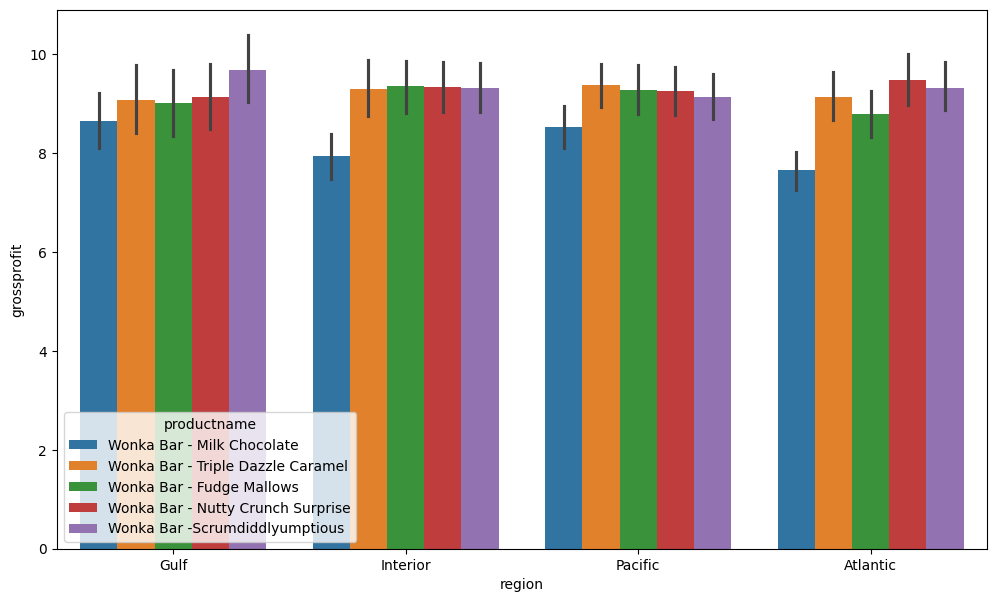

In [87]:
plt.figure(figsize=(12, 7))
sns.barplot(chocolate, x='region' ,y='grossprofit',   hue='productname',)

<Axes: xlabel='region', ylabel='Count'>

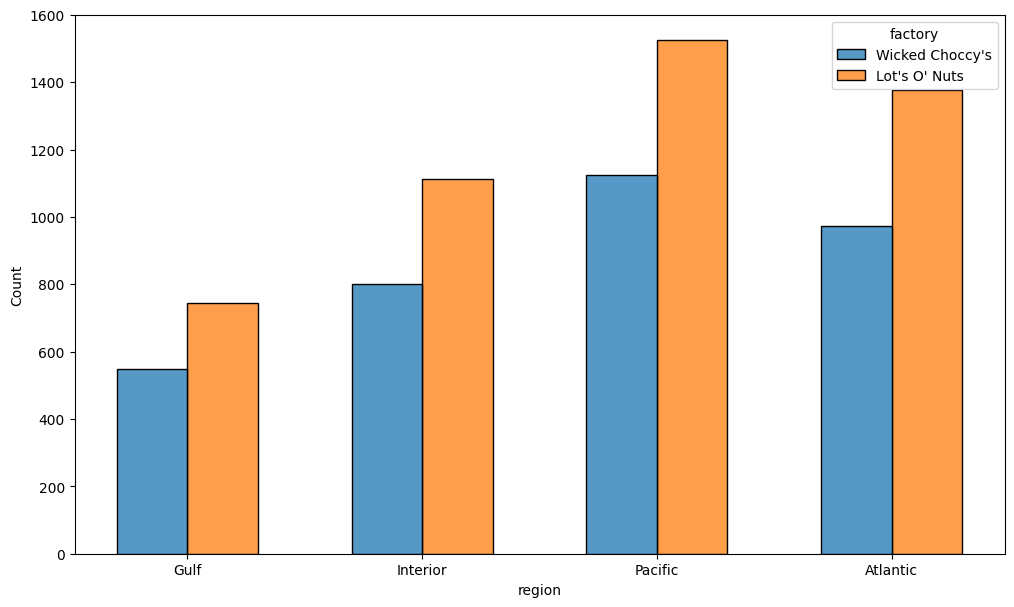

In [88]:
plt.figure(figsize=(12, 7))
sns.histplot(chocolate, x='region' ,  hue='factory', shrink=0.6,  multiple="dodge")

<Axes: xlabel='region', ylabel='grossprofit'>

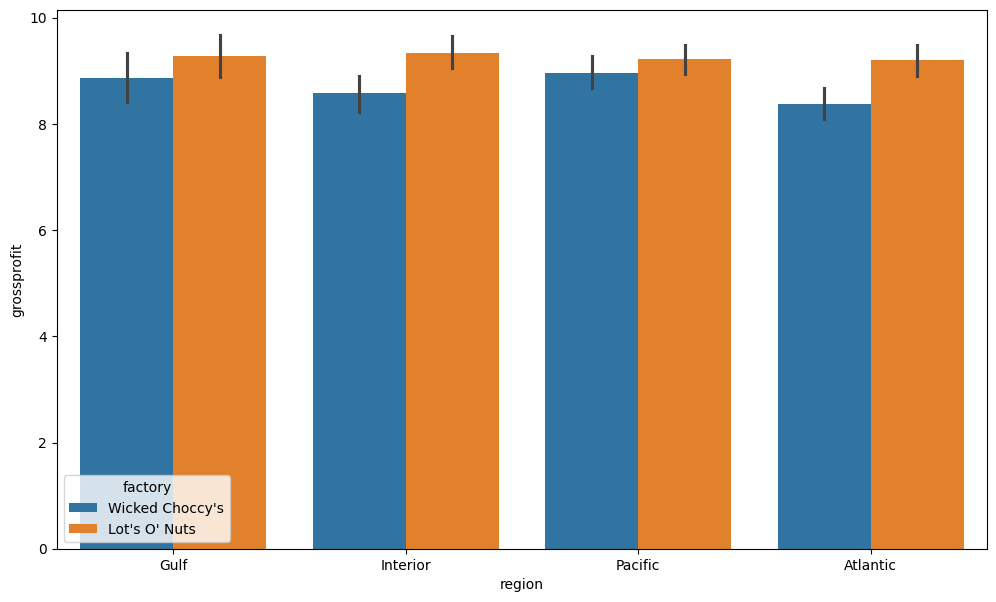

In [89]:
plt.figure(figsize=(12, 7))
sns.barplot(chocolate, x='region' ,y='grossprofit',   hue='factory')

# Sugar

In [90]:
sugar = df[df['division'] =='Sugar']

<Axes: xlabel='region', ylabel='Count'>

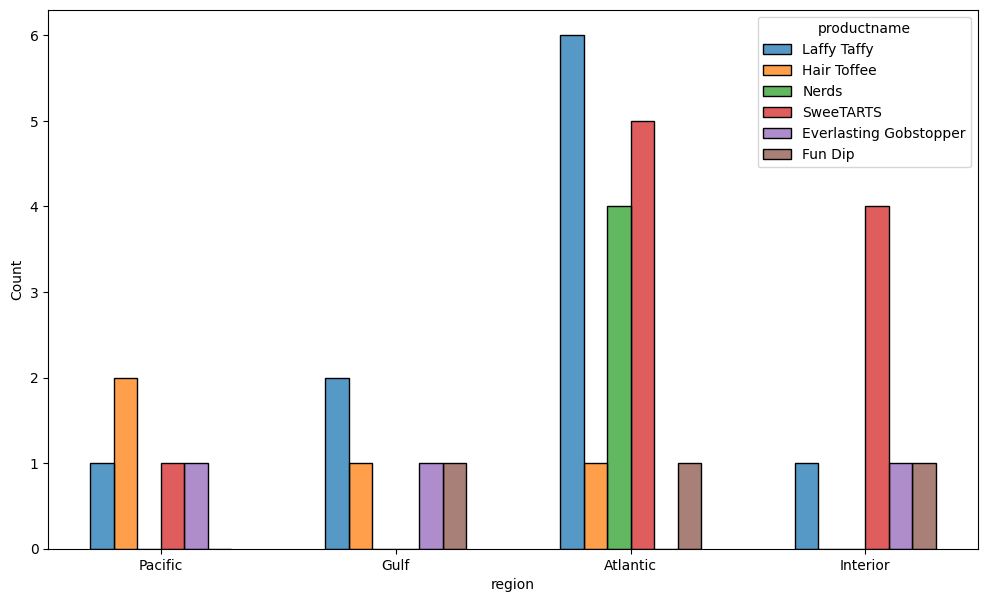

In [91]:
plt.figure(figsize=(12, 7))
sns.histplot(sugar, x='region' ,  hue='productname', shrink=0.6,  multiple="dodge")

<Axes: xlabel='region', ylabel='distances'>

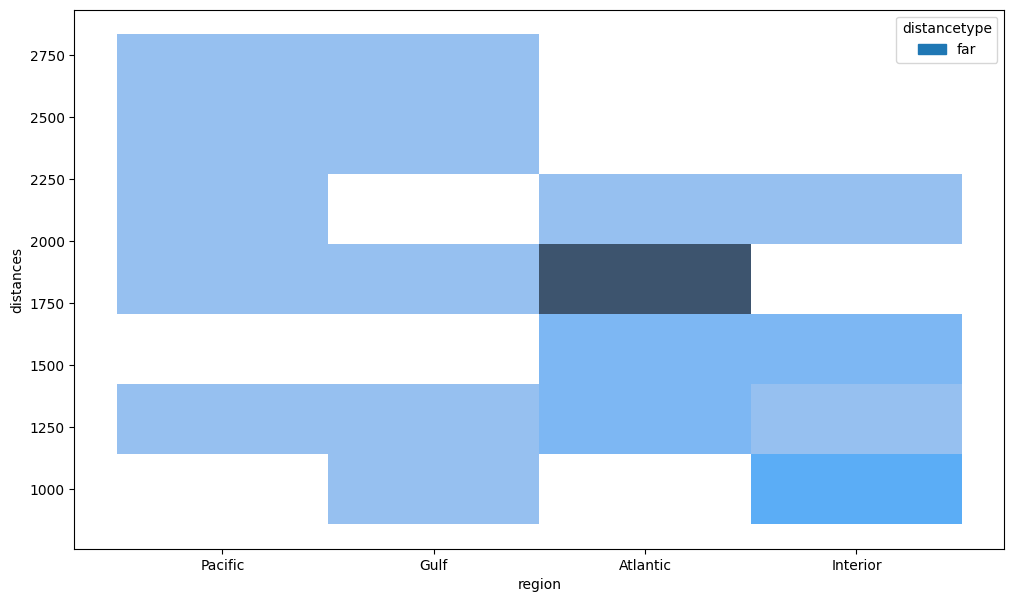

In [92]:
plt.figure(figsize=(12, 7))
sns.histplot(sugar, x='region' ,  y='distances', hue='distancetype',  shrink=0.6)

<Axes: xlabel='region', ylabel='Count'>

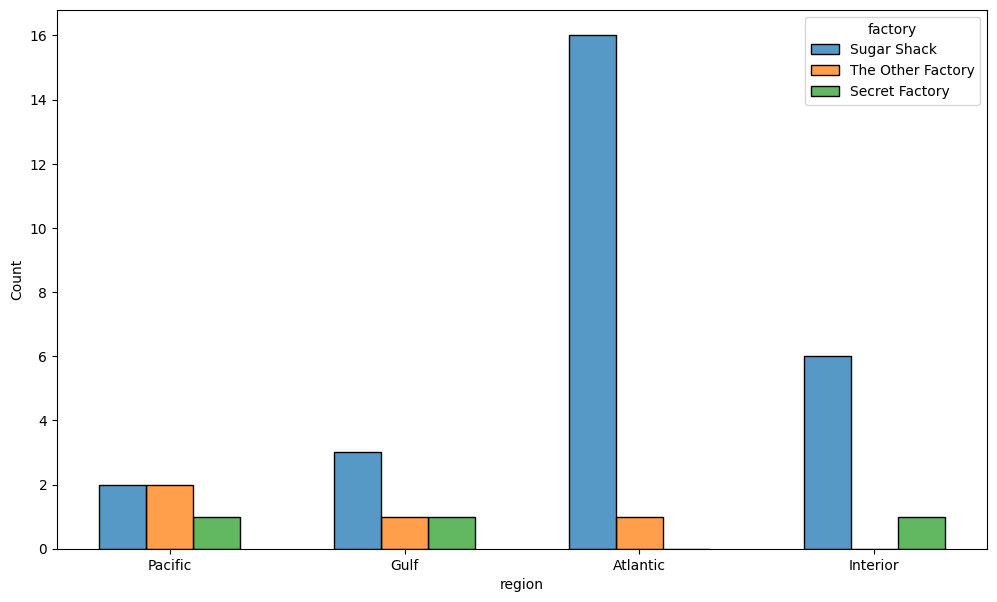

In [93]:
plt.figure(figsize=(12, 7))
sns.histplot(sugar, x='region' ,  hue='factory', shrink=0.6,  multiple="dodge")

<Axes: xlabel='region', ylabel='grossprofit'>

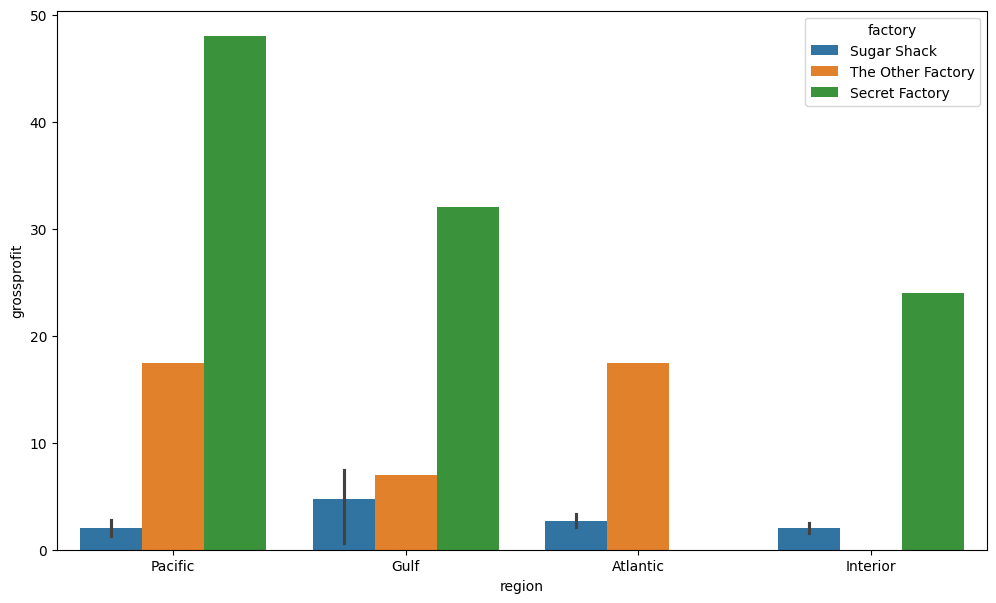

In [94]:
plt.figure(figsize=(12, 7))
sns.barplot(sugar, x='region' ,y='grossprofit',   hue='factory',)

# Other

In [95]:
others = df[df['division'] =='Other']

<Axes: xlabel='region', ylabel='Count'>

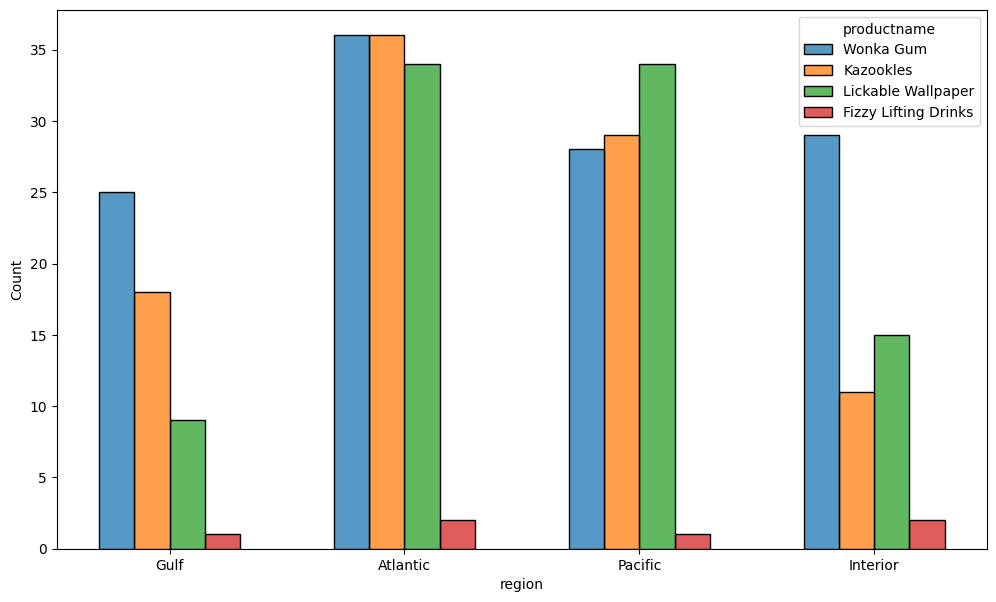

In [96]:
plt.figure(figsize=(12, 7))
sns.histplot(others, x='region' ,  hue='productname', shrink=0.6,  multiple="dodge")

<Axes: xlabel='region', ylabel='Count'>

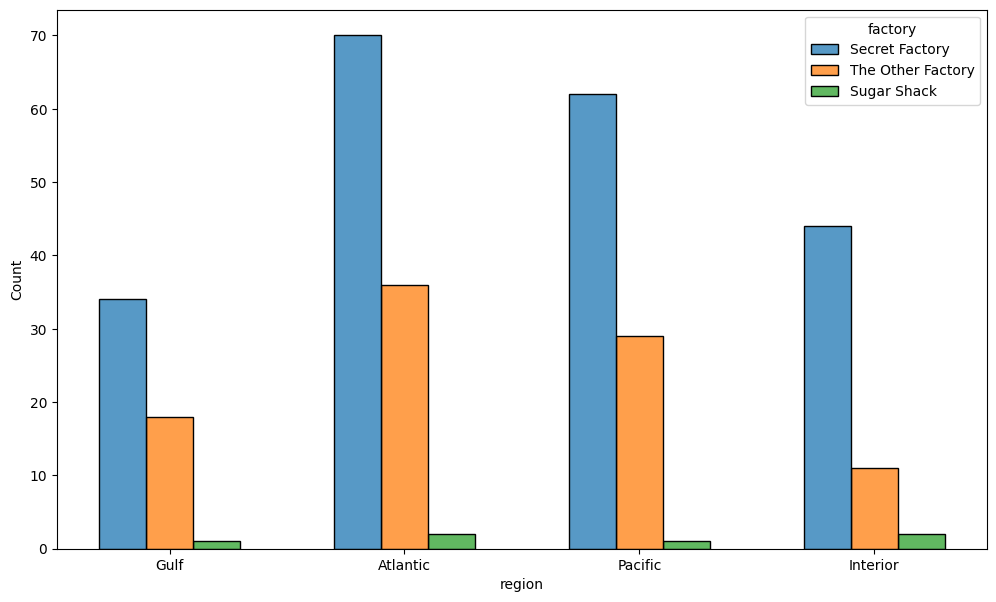

In [97]:
plt.figure(figsize=(12, 7))
sns.histplot(others, x='region' ,  hue='factory', shrink=0.6,  multiple="dodge")

<Axes: xlabel='region', ylabel='grossprofit'>

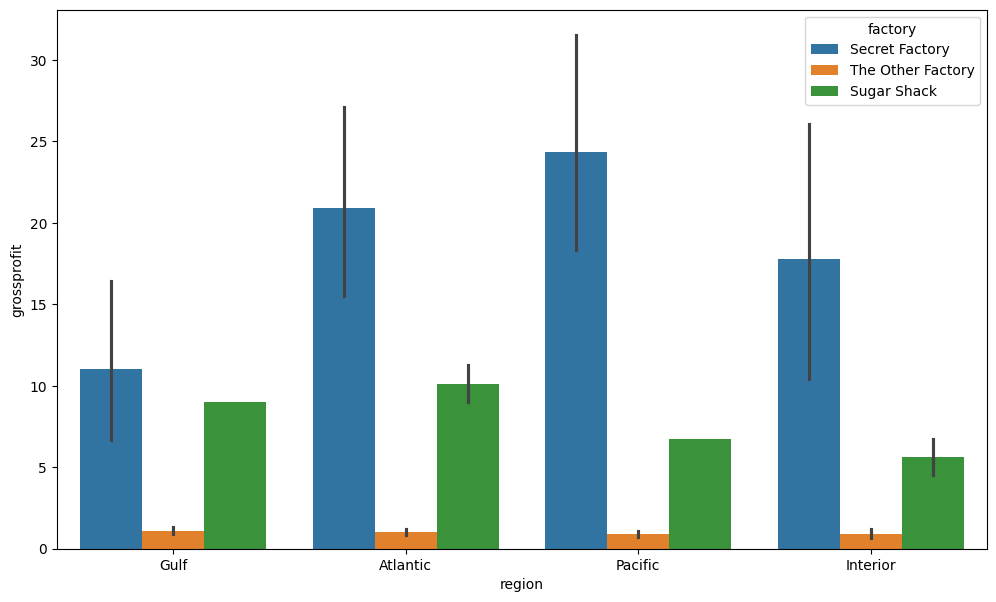

In [98]:
plt.figure(figsize=(12, 7))
sns.barplot(others, x='region' ,y='grossprofit',   hue='factory',)

<Axes: xlabel='region', ylabel='grossprofit'>

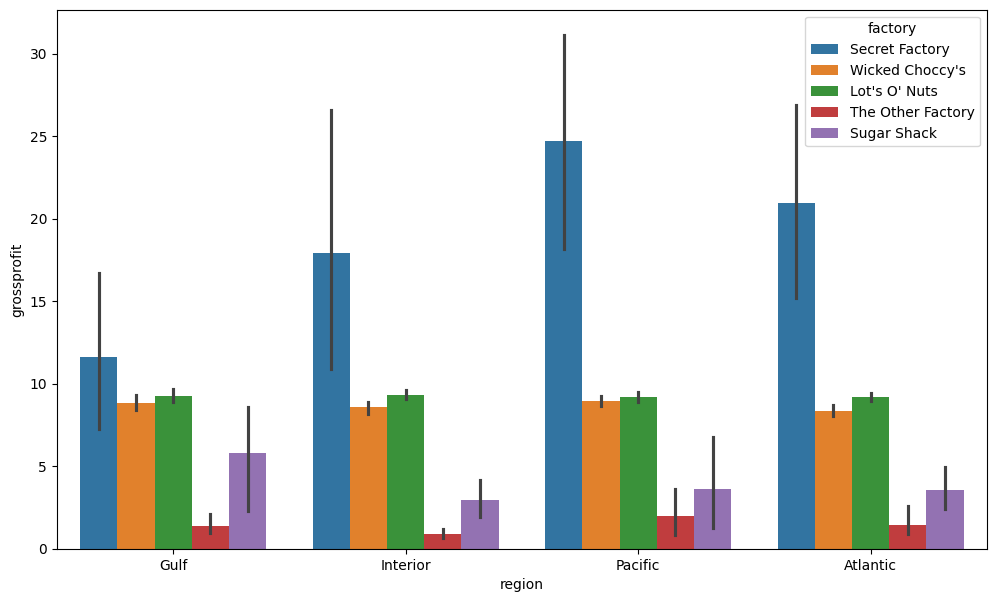

In [99]:
plt.figure(figsize=(12, 7))
sns.barplot(df, x='region' ,y='grossprofit',   hue='factory',)

In [100]:
from mlxtend.frequent_patterns import apriori, association_rules
from mlxtend.preprocessing import TransactionEncoder
import pandas as pd

In [101]:

# Transformation des données pour l’analyse d’association
transactions = df.groupby('customerid')['productname'].apply(list)

# Encoder les transactions
te = TransactionEncoder()
te_ary = te.fit(transactions).transform(transactions)
transaction_df = pd.DataFrame(te_ary, columns=te.columns_)

# Générer les itemsets fréquents
frequent_itemsets = apriori(transaction_df, min_support=0.03, use_colnames=True)

print("Itemsets fréquents:")
frequent_itemsets

# Calcul du nombre de transactions (num_itemsets)
num_itemsets = len(transactions)

# Générer les règles d'association
rules = association_rules(frequent_itemsets, num_itemsets=num_itemsets, metric="lift", min_threshold=1)

print("Règles d'association:")
rules.head(4)[['antecedents','consequents','antecedent support','consequent support' ]]

Itemsets fréquents:
Règles d'association:


,antecedents,consequents,antecedent support,consequent support
0,"(Wonka Bar - Fudge Mallows, Wonka Bar - Milk C...",(Wonka Bar - Triple Dazzle Caramel),0.091594,0.328311
1,"(Wonka Bar - Fudge Mallows, Wonka Bar - Triple...",(Wonka Bar - Milk Chocolate),0.080690,0.345956
2,"(Wonka Bar - Milk Chocolate, Wonka Bar - Tripl...",(Wonka Bar - Fudge Mallows),0.093577,0.297383
3,(Wonka Bar - Fudge Mallows),"(Wonka Bar - Milk Chocolate, Wonka Bar - Tripl...",0.297383,0.093577


- Produit tous les produits chocolatés à la fois chez Lot's O' Nuts et Wicked Choccy's.  
- Sur trois années consécutives, "Sugar Shrack" a enregistré un total de 33 commandes. Nous recommandons donc la fermeture de l'usine "Sugar Shrack" ou sa reconversion en une usine de production de chocolat, en mettant l'accent sur les produits chocolatés les plus consommés dans le nord des États-Unis.  
- En ce qui concerne les produits de "Other Factory", nous recommandons la fermeture de "Other Factory" ou sa reconversion en un point de dépôt pour les produits d'origine chocolatée.  
- Pour "Secret Factory", nous proposons de recentrer la production exclusivement sur les produits de la division "Other" ('Wonka Gum', 'Kazookles', 'Lickable Wallpaper', 'Fizzy Lifting Drinks').  
- Durant les périodes de 

### **1. Optimisation de la production et des stocks**  
- **Prévisions précises** : Analysez les données historiques pour anticiper la demande et ajuster la production en conséquence.  
- **Augmentation des stocks** : Assurez-vous d'avoir un stock suffisant de vos produits les plus populaires pour éviter les ruptures.  
- **Automatisation** : Utilisez des outils ou logiciels pour automatiser certaines étapes de la production et améliorer l'efficacité.  

### **2. Marketing ciblé et promotions**  
- **Promotions saisonnières** : Offrez des réductions, des packs promotionnels ou des cadeaux pour attirer plus de clients.  
- **Campagnes publicitaires** : Augmentez votre visibilité en investissant dans des publicités ciblées sur les réseaux sociaux, les moteurs de recherche ou dans des médias locaux.  
- **Mise en avant des produits phares** : Faites la promotion de vos produits les plus populaires ou adaptés à la saison.  

### **3. Renforcement de la distribution**  
- **Collaboration avec des distributeurs** : Renforcez vos partenariats avec les détaillants pour assurer une meilleure couverture.  
- **Extension des points de vente** : Ajoutez des points de distribution temporaires dans les zones à fort trafic, comme les centres commerciaux.  
- **Livraison optimisée** : Améliorez vos capacités de livraison pour répondre rapidement à la demande croissante.  

### **4. Engagement client et fidélisation**  
- **Expérience client exceptionnelle** : Offrez un excellent service client pour renforcer la satisfaction et fidéliser les clients.  
- **Programmes de fidélité** : Proposez des récompenses ou des points de fidélité pour inciter les clients à revenir.  
- **Feedback des clients** : Collectez des avis pour améliorer vos produits et services en temps réel.  

### **5. Gestion de l'équipe**  
- **Renforcement des équipes** : Recrutez du personnel temporaire pour répondre au surplus de travail.  
- **Formation accélérée** : Formez vos employés pour garantir qu'ils soient prêts à gérer les périodes de forte affluence.  
- **Motivation des équipes** : Proposez des incitations comme des primes pour motiver vos employés à maintenir un haut niveau de performance.  

### **6. Exploitation des outils numériques**  
- **E-commerce** : Mettez en avant vos produits sur votre site web ou via des plateformes en ligne.  
- **Analyse de données** : Utilisez des outils analytiques pour suivre les tendances en temps réel et ajuster vos stratégies.  
- **Réseaux sociaux** : Engagez votre communauté en ligne avec des publications attrayantes et des offres spéciales.  

### Analyses supplémentaires :  
1. **Segmentation des clients**  
   - **KPI** : Valeur à vie du client (CLV), RFM (Récence, Fréquence, Montant)  
   - **Description** : Identifier les groupes de clients pour des stratégies marketing ciblées.  

2. **Analyse des tendances saisonnières**  
   - **KPI** : Taux de variation des ventes par mois/saison  
   - **Description** : Déterminer les périodes de forte demande pour mieux ajuster les promotions et la production.  

3. **Panier moyen**  
   - **KPI** : Montant moyen par transaction  
   - **Description** : Mesurer les performances commerciales et identifier les produits complémentaires.  

4. **Analyse prédictive des ventes**  
   - **KPI** : Croissance projetée, précision des prédictions (%)  
   - **Description** : Utiliser des modèles prédictifs pour anticiper la demande future.  

---

### Analyses précédentes :  
1. **Analyse d’association**  
   - **KPI** : Support, Confiance, Lift  
   - **Description** : Identifier les combinaisons fréquentes de produits pour des ventes croisées.  

2. **Fréquence des achats par produit**  
   - **KPI** : Produits les plus achetés, % des ventes totales  
   - **Description** : Repérer les produits stars pour axer les campagnes marketing.  

3. **Analyse des transactions clients**  
   - **KPI** : Taux de clients récurrents (%)  
   - **Description** : Evaluer la fidélité et encourager les réachats.  

4. **Analyse des performances régionales**  
   - **KPI** : Taux de ventes par région (%)  
   - **Description** : Optimiser les ressources dans les zones à fort potentiel.  

In [102]:
df['factory'].value_counts()

factory
Lot's O' Nuts        4760
Wicked Choccy's      3445
Secret Factory        213
The Other Factory      98
Sugar Shack            33
Name: count, dtype: int64